## Packages

In [2]:
# Setup of the Spark
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u422-b05-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [4]:
import random
import csv
from datetime import datetime, timedelta
import pandas as pd
from collections import defaultdict
import numpy as np
import time
import itertools

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, LongType, ArrayType, IntegerType

from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
# Creating the session
conf = SparkConf()
conf.set("spark.ui.port", "4050")
conf.setAppName("DIS-project")
conf.setMaster("local[*]")
conf.set("spark.driver.memory", "2G")
conf.set("spark.driver.maxResultSize", "2g")
conf.set("spark.executor.memory", "1G")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

## Data Generation - Ready

In [18]:
def generate_synthetic_call_data(num_clients,
                                 call_frequency_range,
                                 call_duration_range,
                                 num_communities_range,
                                 time_range,
                                 save_to_csv=False,
                                 output_file=None,
                                 logs=False):
    clients = list(range(1, num_clients + 1))
    min_duration, max_duration = call_duration_range
    start_time_str, end_time_str = time_range

    start_time = datetime.strptime(start_time_str, '%y%m%d%H%M')
    end_time = datetime.strptime(end_time_str, '%y%m%d%H%M')

    time_diff_minutes = int((end_time - start_time).total_seconds() / 60)

    # Step 1.1: Randomly select the number of communities within the range
    s1 = time.time()
    num_communities = random.randint(num_communities_range[0], num_communities_range[1])

    # Step 1.2: Pre-calculate how many clients each community will have
    community_sizes, remaining_clients = [], num_clients

    for i in range(num_communities - 1):
        size = random.randint(1, remaining_clients - (num_communities - i - 1))  # Ensure remaining clients can be distributed
        community_sizes.append(size)
        remaining_clients -= size

    community_sizes.append(remaining_clients)  # The last community gets the remaining clients

    # Step 1.3: Shuffle the clients list for randomness
    random.shuffle(clients)
    e1 = time.time()
    print(f"Step 1 select # of communities, calc comm size and shuffling took {np.round(e1 - s1, 3)} seconds") if logs else None


    # Step 4: Assign clients to communities based on the predefined sizes
    s4 = time.time()
    communities = []
    current_index = 0

    for size in community_sizes:
        communities.append(clients[current_index:current_index + size])
        current_index += size
    e4 = time.time()
    print(f"Step 4 assign clients to communities finished in {np.round(e4 - s4, 3)} seconds") if logs else None

    call_data = []

    # Step 5: Generate call data for each community
    s5 = time.time()
    for community in communities:
        # Introduce a community-level time shift to vary start times across communities
        community_time_shift = random.randint(0, time_diff_minutes // 5)
        community_start_time = start_time + timedelta(minutes=community_time_shift)

        # Vary the duration range for each community to create different mean durations
        community_min_duration = random.randint(min_duration, max_duration // 2)
        community_max_duration = random.randint(max_duration // 2, max_duration)

        # Vary call frequency for communities: some are more active, others less
        community_call_frequency_range = (
            random.randint(call_frequency_range[0] // 2, call_frequency_range[0]),
            random.randint(call_frequency_range[1], call_frequency_range[1] * 2)
        )

        if len(community) >= 2:
            # Generate call data between two random clients in the community
            first_client, second_client = random.sample(community, 2)
            call_data.append(generate_call(first_client, second_client, community_start_time, time_diff_minutes, community_min_duration, community_max_duration))

        for client in community:
            call_frequency = random.randint(community_call_frequency_range[0], community_call_frequency_range[1])

            for _ in range(call_frequency):
                other_client = random.choice(community)
                while other_client == client:
                    other_client = random.choice(community)
                call_data.append(generate_call(client, other_client, community_start_time, time_diff_minutes, community_min_duration, community_max_duration))
    e5 = time.time()
    print(f"Step 5 generate call data finished in {np.round(e5 - s5, 3)} seconds") if logs else None

    # Step 6: Optionally save to CSV
    if save_to_csv and output_file:
        s6 = time.time()
        with open(output_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['c1', 'c2', 'start', 'end'])
            writer.writerows(call_data)
        e6 = time.time()
        print(f"Step 6 save to CSV finished in {np.round(e6 - s6, 3)} seconds") if logs else None

    # Step 7: Create and return a PySpark DataFrame
    s7 = time.time()
    call_df = spark.createDataFrame(call_data, schema=['c1', 'c2', 'start', 'end'])
    e7 = time.time()
    print(f"Step 7 create PySpark DataFrame finished in {np.round(e7 - s7, 3)} seconds") if logs else None
    return call_df


def generate_call(client_a,
                  client_b,
                  start_time,
                  time_diff_minutes,
                  min_duration,
                  max_duration):
    # Random call start time within the time range
    random_minutes = random.randint(0, time_diff_minutes)
    call_start_time = start_time + timedelta(minutes=random_minutes)

    # Vary call duration by adding randomness to the duration range
    call_duration = random.randint(min_duration, max_duration)

    call_end_time = call_start_time + timedelta(minutes=call_duration)

    # Randomly add variability to start and end times (like delays or extensions)
    additional_random_minutes = random.randint(-5, 10)
    call_start_time += timedelta(minutes=additional_random_minutes)
    call_end_time += timedelta(minutes=random.randint(-2, 5))

    call_start_str = call_start_time.strftime('%y%m%d%H%M')
    call_end_str = call_end_time.strftime('%y%m%d%H%M')

    return (client_a, client_b, call_start_str, call_end_str)
    # return [client_a, client_b, call_start_str, call_end_str]


## Community Creation - Ready

In [23]:
def dfs(client, community, visited, graph):
    stack = [client]
    visited.add(client)

    while stack:
        node = stack.pop()
        community.append(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                visited.add(neighbor)
                stack.append(neighbor)

def find_communities(call_df,
                     logs=False):
    # Step 1: Build the graph from call data in a distributed manner
    s1 = time.time()
    graph_df = call_df.select("c1", "c2").distinct()
    e1 = time.time()
    print(f"Step 1 build graph finished in {np.round(e1 - s1, 3)} seconds") if logs else None

    # Step 2: Aggregate the data to create connections between clients
    s2 = time.time()
    client_graph = (
        graph_df
        .withColumn("client_pair", F.array("c1", "c2"))
        .select(F.explode("client_pair").alias("client"), "c1", "c2")
        .groupBy("client")
        .agg(F.collect_set(F.when(F.col("client") == F.col("c1"), F.col("c2")).otherwise(F.col("c1"))).alias("connections"))
    )
    e2 = time.time()
    print(f"Step 2 aggregate data finished in {np.round(e2 - s2, 3)} seconds") if logs else None

    # Step 3: Collect the graph as a dictionary for DFS traversal
    s3 = time.time()
    graph = defaultdict(list)
    for row in client_graph.collect():
        client = row["client"]
        connections = row["connections"]
        graph[client].extend(connections)
    e3 = time.time()
    print(f"Step 3 collect graph finished in {np.round(e3 - s3, 3)} seconds") if logs else None

    # Step 4: Find connected components using DFS
    s4 = time.time()
    visited = set()
    client_to_community = {}
    community_counter = 1

    for client in graph:
        if client not in visited:
            community = []
            dfs(client, community, visited, graph)

            # Assign a community number to each client in the community
            for member in community:
                client_to_community[member] = community_counter
            community_counter += 1
    e4 = time.time()
    print(f"Step 4 DFS traversal finished in {np.round(e4 - s4, 3)} seconds") if logs else None

    # Step 5: Return RDD of (client, community_number)
    s5 = time.time()
    client_to_community_rdd = spark.sparkContext.parallelize([(client, comm_number) for client, comm_number in client_to_community.items()])
    e5 = time.time()
    print(f"Step 5 convert to RDD finished in {np.round(e5 - s5, 3)} seconds") if logs else None

    # Step 6: Validate result by counting unique communities
    s6 = time.time()
    unique_comms_count = client_to_community_rdd.map(lambda x: x[1]).distinct().count()
    e6 = time.time()
    print(f"Step 6 count unique communities finished in {np.round(e6 - s6, 3)} seconds") if logs else None
    print(f"Number of unique communities found: {unique_comms_count}")

    return client_to_community_rdd


## Similarity Check - Ready

In [27]:
def normalized_difference(val1, val2):
    """Calculate the normalized difference between two values."""
    # Handle None values for val1 or val2
    if val1 is None or val2 is None:
        return 0  # Or another appropriate default value

    # Normalize difference based on the maximum of the two values
    norm_diff = np.abs(val1 - val2) / np.max([val1, val2]) if np.max([val1, val2]) != 0 else 0
    return norm_diff

def compute_similarity(comm1_number: int, comm2_number: int,
                       num_clients1: int, mean_duration1: float, stddev_duration1: float, total_duration1: float,
                       num_clients2: int, mean_duration2: float, stddev_duration2: float, total_duration2: float,
                       logs = False) -> float:
    """Compute the similarity score between two communities."""

    print(f"\nComparing Community {comm1_number} with Community {comm2_number}:") if logs else None
    # Normalize each metric and print the values
    norm_num_clients = normalized_difference(num_clients1, num_clients2)
    print(f"Normalized number of clients difference: {norm_num_clients:.4f}") if logs else None

    norm_mean_duration = normalized_difference(mean_duration1, mean_duration2)
    print(f"Normalized mean duration difference: {norm_mean_duration:.4f}") if logs else None

    norm_stddev_duration = normalized_difference(stddev_duration1, stddev_duration2)
    print(f"Normalized stddev duration difference: {norm_stddev_duration:.4f}") if logs else None

    norm_total_duration = normalized_difference(total_duration1, total_duration2)
    print(f"Normalized total duration difference: {norm_total_duration:.4f}") if logs else None

    # Compute similarity score (as per previous formulas)
    similarity_score = 1 - (1 / 4) * (norm_num_clients + norm_mean_duration + norm_stddev_duration + norm_total_duration)

    # Print the final similarity score
    print(f"Final similarity score: {similarity_score:.4f}") if logs else None

    return similarity_score


def group_similar_communities(call_df: DataFrame,
                              client_to_community_rdd,
                              filename,
                              save_to_txt=False,
                              logs=True) -> DataFrame:
    """Group similar communities based on similarity metrics calculated from call data."""
    THRESHOLD = 0.8  # Set threshold for similarity score

    # Step 1: Convert RDD to DataFrame and join with the original call data
    s1 = time.time()

    comm_df = client_to_community_rdd.toDF(["client", "community_number"])

    enriched_df = call_df.join(comm_df, call_df["c1"] == comm_df["client"], "left").drop("client")
    enriched_df = enriched_df.withColumnRenamed("community_number", "comm_number_c1")
    enriched_df = enriched_df.join(comm_df, call_df["c2"] == comm_df["client"], "left").drop("client")
    enriched_df = enriched_df.withColumnRenamed("community_number", "comm_number_c2")

    enriched_df = enriched_df.withColumn(
        "comm_number", F.coalesce(F.col("comm_number_c1"), F.col("comm_number_c2"))
    ).drop("comm_number_c1", "comm_number_c2")

    # Convert durations to minutes (assuming 'start' and 'end' are in seconds)
    enriched_df = enriched_df.withColumn("duration", (enriched_df["end"] - enriched_df["start"]) / 60.0)
    e1 = time.time()
    print(f"Step 1 convert RDD to DataFrame and join with the original call data finished {np.round(e1 - s1, 3)} seconds") if logs else None

    # Step 2: Calculate community metrics
    s2 = time.time()
    community_metrics = (
        enriched_df.groupBy("comm_number")
        .agg(
            F.countDistinct("c1").alias("num_clients"),
            F.mean("duration").alias("mean_duration"),
            F.stddev("duration").alias("stddev_duration"),
            F.sum("duration").alias("total_duration")
        )
    )
    e2 = time.time()
    print(f"Step 2 calculate community metrics finished {np.round(e2 - s2, 3)} seconds") if logs else None

    # Step 3: Compare communities using similarity formula
    s3 = time.time()
    community_data = community_metrics.collect()

    similar_communities = []
    assigned_groups = {}

    for i in range(len(community_data)):
        for j in range(i + 1, len(community_data)):
            comm1 = community_data[i]
            comm2 = community_data[j]

            # Calculate similarity using the combined similarity score
            similarity_value = compute_similarity(
                  comm1.comm_number, comm2.comm_number,
                  comm1.num_clients, comm1.mean_duration, comm1.stddev_duration, comm1.total_duration,
                  comm2.num_clients, comm2.mean_duration, comm2.stddev_duration, comm2.total_duration
              )

            # Store similarity results
            similar_communities.append((comm1.comm_number, comm2.comm_number, similarity_value))

            if similarity_value >= THRESHOLD:
                # Ensure communities only belong to one group
                group1 = assigned_groups.get(comm1.comm_number, set())
                group2 = assigned_groups.get(comm2.comm_number, set())

                if not group1 and not group2:
                    # Create a new group for both communities
                    new_group = {comm1.comm_number, comm2.comm_number}
                    assigned_groups[comm1.comm_number] = new_group
                    assigned_groups[comm2.comm_number] = new_group
                elif group1 and not group2:
                    # Add comm2 to comm1's group
                    group1.add(comm2.comm_number)
                    assigned_groups[comm2.comm_number] = group1
                elif group2 and not group1:
                    # Add comm1 to comm2's group
                    group2.add(comm1.comm_number)
                    assigned_groups[comm1.comm_number] = group2
                else:
                    # Merge the two groups
                    merged_group = group1.union(group2)
                    for comm in merged_group:
                        assigned_groups[comm] = merged_group
    e3 = time.time()
    print(f"Step 3 compare communities using similarity formula finished {np.round(e3 - s3, 3)} seconds") if logs else None


    # Step 4: Group similar communities and save final groups to a text file
    s4 = time.time()
    final_groups = {}
    for comm, group in assigned_groups.items():
        group_key = tuple(sorted(group))  # Use sorted tuple as a key for grouping
        if group_key not in final_groups:
            final_groups[group_key] = group_key

    # Ensure that ungrouped communities are also included in the final output
    ungrouped_communities = set(comm.comm_number for comm in community_data) - set(assigned_groups.keys())
    if ungrouped_communities:  # Check if there are any ungrouped communities
        for comm in ungrouped_communities:
            final_groups[frozenset({comm})] = frozenset({comm})
    e4 = time.time()
    print(f"Step 4 group similar communities took {np.round(e4 - s4, 3)} seconds") if logs else None

    # Step 5 printing and saving
    gr_num = 1
    s5 = time.time()
    if save_to_txt:
        # Step 5.1: Group the DataFrame by communities and collect all the necessary data at once
        s51 = time.time()
        community_calls = (
            enriched_df.groupBy("comm_number")
            .agg(F.collect_list(F.struct("c1", "c2", "start", "end")).alias("calls"))
            .collect()
        )
        e51 = time.time()
        print(f"Step 5.1 collect all data at once finished {np.round(e51 - s51, 3)} seconds") if logs else None

        # Step 5.2: Build the text output in memory and then write it all at once
        s52 = time.time()
        output_lines = []

        for group_key in final_groups:
            output_lines.append(f"Group {gr_num}:\n")
            print(f"Group {gr_num}: " + ", ".join(f"c{comm}" for comm in group_key))
            comm_num = 1

            for comm in group_key:
                output_lines.append(f"  Community {comm_num}:\n")

                # Find the community data in the pre-collected results
                comm_data = next((comm_row.calls for comm_row in community_calls if comm_row.comm_number == comm), [])

                # Format the call data for each community
                for call in comm_data:
                    output_lines.append(f"    {call['c1']}, {call['c2']}, {call['start']}, {call['end']}\n")

                comm_num += 1

            output_lines.append("\n")
            gr_num += 1
        e52 = time.time()
        print(f"Step 5.2 build text output in memory finished {np.round(e52 - s52, 3)} seconds") if logs else None

        # Step 5.3: Write all lines to the file at once
        s53 = time.time()
        with open(f'{filename}.txt', 'w') as f:
            f.writelines(output_lines)
        e53 = time.time()
        print(f"Step 5.3 write all lines to the file {np.round(e53 - s53, 3)} seconds") if logs else None
    else:
        for group_key in final_groups:
            print(f"Group {gr_num}: " + ", ".join(f"c{comm}" for comm in group_key))
            gr_num += 1
    e5 = time.time()
    print(f"Step 5 write all lines to the file at once finished {np.round(e5 - s5, 3)} seconds") if logs else None

    # Prepare DataFrame output (if needed for further processing)
    group_data = [(list(group),) for group in final_groups.values()]
    schema = StructType([StructField("grouped_communities", ArrayType(IntegerType()), True)])
    return spark.createDataFrame(group_data, schema=schema)

## Simple test run

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, LongType

# test2.csv
data = [
    (1, 2, '2408010800', '2408010830'),
    (2, 3, '2408010900', '2408010930'),
    (1, 3, '2408011000', '2408011030'),
    (4, 5, '2408011100', '2408011130'),
    (5, 6, '2408011200', '2408011230'),
    (6, 7, '2408011300', '2408011330'),
    (4, 7, '2408011400', '2408011430'),
    (8, 9, '2408011500', '2408011530')
]

# test1.csv
data = [
    (1, 4, '2408010800', '2408010830'),
    (4, 6, '2408021000', '2408021030'),
    (1, 6, '2408021100', '2408021130'),
    (2, 3, '2408010900', '2408010930'),
    (3, 5, '2408010930', '2408011000'),
    (5, 7, '2408021400', '2408021430'),
    (2, 7, '2408030800', '2408030830'),
]


schema = StructType([
    StructField("c1", LongType(), True),
    StructField("c2", LongType(), True),
    StructField("start", StringType(), True),
    StructField("end", StringType(), True)
])

call_df = spark.createDataFrame(data, schema=schema)
call_df.show()

+---+---+----------+----------+
| c1| c2|     start|       end|
+---+---+----------+----------+
|  1|  4|2408010800|2408010830|
|  4|  6|2408021000|2408021030|
|  1|  6|2408021100|2408021130|
|  2|  3|2408010900|2408010930|
|  3|  5|2408010930|2408011000|
|  5|  7|2408021400|2408021430|
|  2|  7|2408030800|2408030830|
+---+---+----------+----------+



In [21]:
# Step 1: Generate synthetic call data
start_time_data_creation = time.time()

call_df = generate_synthetic_call_data(
    num_clients=100_000,
    call_frequency_range=(2, 3),
    call_duration_range=(20, 600000),
    num_communities_range=(5, 6),
    time_range=('2401010000', '2412312359'),
    save_to_csv=False,
    logs=True
)

end_time_data_creation = time.time()
time_secs_data_creation = np.round(end_time_data_creation - start_time_data_creation, 3)
print(f"Execution time for data creation: {time_secs_data_creation} seconds")

Step 1 select number of communities finished in 0.0 seconds
Step 2 calculate community sizes finished in 0.0 seconds
Step 3 shuffle clients finished in 0.319 seconds
Step 4 assign clients to communities finished in 0.009 seconds
Step 5 generate call data finished in 4.754 seconds
Step 7 create PySpark DataFrame finished in 10.259 seconds
Execution time for data creation: 15.404 seconds


In [24]:
# ______________________________________________________________________________________________________
# Step 2: Find communities and assign community numbers (now returns DataFrame with `comm_number`)
start_time_community_finding = time.time()

comms_rdd = find_communities(call_df, logs=True)

end_time_community_finding = time.time()
time_secs_community_finding = np.round(end_time_community_finding - start_time_community_finding, 3)
print(f"Execution time for community finding: {time_secs_community_finding} seconds")

comms_list = comms_rdd.collect()
community_counts = {}

for client, community in comms_list:
    community_counts[community] = community_counts.get(community, 0) + 1  # Use get with default value of 0

for community, count in community_counts.items():
    print(f"Community {community} has {count} clients.")

Step 1 build graph finished in 0.07 seconds
Step 2 aggregate data finished in 0.223 seconds
Step 3 collect graph finished in 6.977 seconds
Step 4 DFS traversal finished in 0.376 seconds
Step 5 convert to RDD finished in 0.141 seconds
Step 6 count unique communities finished in 1.168 seconds
Number of unique communities found: 5
Execution time for community finding: 9.006 seconds
Community 1 has 99472 clients.
Community 2 has 184 clients.
Community 3 has 71 clients.
Community 4 has 56 clients.
Community 5 has 217 clients.


In [28]:
# ______________________________________________________________________________________________________
# Step 3: Group similar communities (this step will still work with the community DataFrame)
start_time_similarity_check = time.time()

groups = group_similar_communities(call_df, comms_rdd, 100, save_to_txt=True)

end_time_similarity_check = time.time()
time_secs_similarity_check = np.round(end_time_community_finding - start_time_community_finding, 3)
print(f"Execution time for community grouping: {time_secs_similarity_check} seconds")

Step 1 convert RDD to DataFrame and join with the original call data finished 0.313 seconds
Step 2 calculate community metrics finished 0.054 seconds
Step 3 compare communities using similarity formula finished 2.957 seconds
Step 4 group similar communities took 0.0 seconds
Step 5.1 collect all data at once finished 7.826 seconds
Group 1: c2, c5
Group 2: c3, c4
Group 3: c1
Step 5.2 build text output in memory finished 1.025 seconds
Step 5.3 write all lines to the file 0.063 seconds
Step 5 write all lines to the file at once finished 8.915 seconds
Execution time for community grouping: 9.006 seconds


## Data Creation and Save

In [ ]:
num_clients = np.arange(100_000, 1_000_000, 300_000)
num_clients = [100_000, 300_000, 800_000, 1_000_000, 1_500_000, 2_000_000, 5_000_000, 10_000_000]
call_frequency = (0, 1)
call_duration_range = (20, 60000)
num_communities_range = (3, 7)  # Define the range for the number of communities
time_range = ('2401010000', '2412312359')

for nc in num_clients:
    print(f"For {nc} clients...")
    # Step 1: Generate synthetic call data
    start_time_data_creation = time.time()

    call_df = generate_synthetic_call_data(
        num_clients=nc,
        call_frequency_range=call_frequency,
        call_duration_range=call_duration_range,
        num_communities=num_communities_range,
        time_range=time_range,
        save_to_csv=True,
        output_file=f'data/{nc}.csv'
    )

    end_time_data_creation = time.time()
    time_secs_data_creation = np.round(end_time_data_creation - start_time_data_creation, 3)
    print(f"Execution time for data creation: {time_secs_data_creation} seconds")


For 100000 clients...
Execution time for data creation: 6.798 seconds
For 300000 clients...
Execution time for data creation: 16.07 seconds
For 800000 clients...
Execution time for data creation: 41.58 seconds
For 1000000 clients...
Execution time for data creation: 44.078 seconds
For 1500000 clients...
Execution time for data creation: 94.088 seconds
For 2000000 clients...
Execution time for data creation: 99.325 seconds
For 5000000 clients...
Execution time for data creation: 217.677 seconds
For 10000000 clients...
Execution time for data creation: 347.898 seconds


## Test Runs All Together

In [ ]:
num_clients = [10_000, 100_000, 300_000, 800_000, 1_000_000, 1_500_000, 2_000_000, 5_000_000, 10_000_000]
# num_clients = [1000, 2000]
call_frequency = (2, 3)
call_duration_range = (20, 60000)
num_communities_range = (3, 7)
time_range = ('2401010000', '2412312359')

results = {
    'num_clients': [],
    'call_freq': [],
    'time_secs_data_creation': [],
    'time_secs_community_finding': [],
    'time_secs_similarity_finding': [],
    'time_secs_total': [],
    'num_comms': [],
}

for num_client in num_clients:
    print(f"For {num_client} clients...")
    # Step 1: Generate synthetic call data
    start_time_data_creation = time.time()

    call_df = generate_synthetic_call_data(
        num_clients=num_client,
        call_frequency_range=(2, 3),
        call_duration_range=(20, 600000),
        num_communities_range=(5, 6),
        time_range=('2401010000', '2412312359'),
        save_to_csv=True,
        output_file=f'data/{num_client}.csv',
        logs=False
    )
    # call_df = spark.read.csv(f'data/{num_client}.csv', header=True, inferSchema=True)

    end_time_data_creation = time.time()
    time_secs_data_creation = np.round(end_time_data_creation - start_time_data_creation, 3)
    print(f"Execution time for data creation: {time_secs_data_creation} seconds")

    # ______________________________________________________________________________________________________
    # Step 2: Find communities and assign community numbers (now returns DataFrame with `comm_number`)
    start_time_community_finding = time.time()

    comms_rdd = find_communities(call_df, logs=False)

    end_time_community_finding = time.time()
    time_secs_community_finding = np.round(end_time_community_finding - start_time_community_finding, 3)
    print(f"Execution time for community finding: {time_secs_community_finding} seconds")

    num_comms = comms_rdd.map(lambda x: x[1]).distinct().count()

    # ______________________________________________________________________________________________________
    # Step 3: Group similar communities (this step will still work with the community DataFrame)
    start_time_similarity_check = time.time()

    groups = group_similar_communities(call_df, comms_rdd, num_client, logs=False)

    end_time_similarity_check = time.time()
    time_secs_similarity_check = np.round(end_time_similarity_check - start_time_similarity_check, 3)
    print(f"Execution time for community grouping: {time_secs_similarity_check} seconds")

    # ______________________________________________________________________________________________________
    # Calculate total time and store results
    total_time = np.round(
        time_secs_data_creation + time_secs_community_finding + time_secs_similarity_check, 3
    )
    print(f"Total execution time: {total_time} seconds")

    results['num_clients'].append(num_client)
    results['call_freq'].append(call_frequency)  # Add call frequency as a fixed value
    results['time_secs_data_creation'].append(time_secs_data_creation)
    results['time_secs_community_finding'].append(time_secs_community_finding)
    results['time_secs_similarity_finding'].append(time_secs_similarity_check)
    results['time_secs_total'].append(total_time)
    results['num_comms'].append(num_comms)
    print("========="*7)

# Convert results to DataFrame and save to CSV
result_df = pd.DataFrame(results)
result_df.to_csv('data/performance_results.csv', index=False)

For 10000 clients...
Execution time for data creation: 2.159 seconds
Number of unique communities found: 6
Execution time for community finding: 2.319 seconds
Group 1: c1
Group 2: c2
Group 3: c3
Group 4: c4
Group 5: c5
Group 6: c6
Execution time for community grouping: 1.938 seconds
Total execution time: 6.416 seconds
For 100000 clients...
Execution time for data creation: 19.877 seconds
Number of unique communities found: 5
Execution time for community finding: 6.446 seconds
Group 1: c3, c4
Group 2: c1
Group 3: c2
Group 4: c5
Execution time for community grouping: 3.097 seconds
Total execution time: 29.42 seconds
For 300000 clients...
Execution time for data creation: 56.391 seconds
Number of unique communities found: 5
Execution time for community finding: 15.842 seconds
Group 1: c3, c4, c5
Group 2: c1
Group 3: c2
Execution time for community grouping: 6.114 seconds
Total execution time: 78.347 seconds
For 800000 clients...
Execution time for data creation: 103.849 seconds
Number of 

In [ ]:
result_df.head(10)

,num_clients,call_freq,time_secs_data_creation,time_secs_community_finding,time_secs_similarity_finding,time_secs_total,num_comms
0,1000,"(1, 2)",0.132,2.215,11.145,13.492,5
1,2000,"(1, 2)",0.843,2.172,49.384,52.399,21


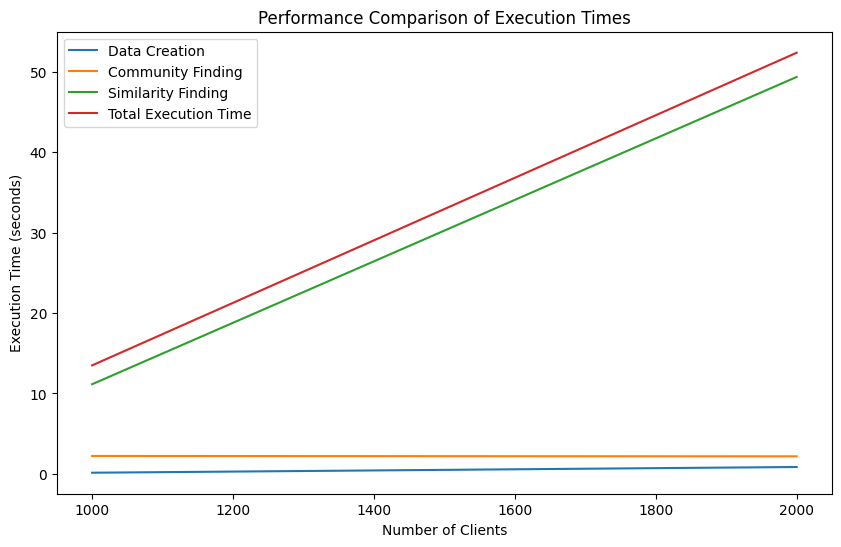

In [ ]:
import matplotlib.pyplot as plt

# Sort the DataFrame by number of clients
df = result_df.sort_values(by='num_clients')

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot different execution times
ax.plot(df['num_clients'], df['time_secs_data_creation'], label='Data Creation')
ax.plot(df['num_clients'], df['time_secs_community_finding'], label='Community Finding')
ax.plot(df['num_clients'], df['time_secs_similarity_finding'], label='Similarity Finding')
ax.plot(df['num_clients'], df['time_secs_total'], label='Total Execution Time')

# Set labels and title
ax.set_xlabel('Number of Clients')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Performance Comparison of Execution Times')
ax.legend()

# Display the plot
plt.show()
